# ICESpark Ice Sat 2 Orbit Crossing + MOSAiC Master track of POLARSTERN cruise


In [1]:
import os

import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, expr, broadcast

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter

In [2]:
spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("spark.kryoserializer.buffer.max", '200').\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
    getOrCreate()
# spark.kryoserializer.buffer.max Broadcast buffer size, in MB

In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

## Load ICE_SAT2 orbits (size 2.6GB, 13704 orbits) into Spark
Files are originally in KML. They are converted to a single WKT file using GDAL ogr2ogr command.

Filename example: IS2_RGT_0702_cycle3_14-May-2019.kml.csv

In [4]:
ice2_df = spark.read.format("csv").\
    option("delimiter", ",").\
    option("header", "true").\
    load("data/IS2_RGTs_aggr_data_timestamp-head1000.csv").repartition(10)

ice2_df.createOrReplaceTempView("is2_df_raw")

ice2_df.show(2)

print(ice2_df.count())


+--------------------+------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|                 WKT|  Name|description|timestamp|begin| end| altitudeMode|tessellate|extrude|visibility|drawOrder|icon|            filename|
+--------------------+------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|LINESTRING (-70.8...| RGT 4|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0004_cycl...|
|LINESTRING (-41.7...|RGT 18|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0018_cycl...|
+--------------------+------+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
only showing top 2 rows

15091


## Create an UDF to transform the date column

In [5]:
from datetime import datetime
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf
def orbit_date(s):
  length = len(s)
  date_str = s[(length-19):(length-8)]
  date_obj = datetime.strptime(date_str, '%d-%b-%Y')
  return date_obj.strftime("%Y-%m-%d")
def orbit_filter_dirty(s):
  if len(s) < 20:
    return False
  else:
    return True
def cruise_date(s):
  return s[0:10]
spark.udf.register("orbit_date", orbit_date)
spark.udf.register("cruise_date", cruise_date)
spark.udf.register("orbit_filter_dirty", orbit_filter_dirty)
orbit_filter_dirty_udf = udf(orbit_filter_dirty, BooleanType())

## Create DataFrame - Select Year 2020 data

In [6]:
ice2_df = spark.sql("select ST_FlipCoordinates(ST_GeomFromWKT(WKT)) as orbit, Name, altitudeMode, tessellate, extrude, visibility, filename from is2_df_raw")
ice2_df = ice2_df.filter("filename LIKE \'%2020.kml.csv%\'").withColumn("date", expr("orbit_date(filename)"))
# ice2_df.createOrReplaceTempView("is2_df")
ice2_df.show(2)
ice2_df.select("filename").show(2, truncate = False)
print(ice2_df.count())

+--------------------+-------+-------------+----------+-------+----------+--------------------+----------+
|               orbit|   Name| altitudeMode|tessellate|extrude|visibility|            filename|      date|
+--------------------+-------+-------------+----------+-------+----------+--------------------+----------+
|LINESTRING (0.066...|RGT 110|clampToGround|        -1|      0|         1|IS2_RGT_0110_cycl...|2020-12-31|
|LINESTRING (0.051...| RGT 71|clampToGround|        -1|      0|         1|IS2_RGT_0071_cycl...|2020-09-28|
+--------------------+-------+-------------+----------+-------+----------+--------------------+----------+
only showing top 2 rows

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0098_cycle7_01-Apr-2020.kml.csv|
|IS2_RGT_0076_cycle8_30-Jun-2020.kml.csv|
+---------------------------------------+
only showing top 2 rows

5590


## Load Master track of POLARSTERN cruise into Spark (Leg 1- 4, 1.2 GB, 28222065 coordinates)

In [7]:
cruise_df = spark.read.format("csv").\
    option("delimiter", "\t").\
    option("header", "true").\
    load("data/PS122*head1000.txt").\
    filter(col("Latitude").isNotNull()).\
    filter(col("Longitude").isNotNull()).\
    repartition(100)
cruise_df.show(2)

+-------------------+----------+---------+--------------------+
|    Date/Time (UTC)|  Latitude|Longitude|Flag for data source|
+-------------------+----------+---------+--------------------+
|2020-06-25T02:01:37|82.0571156|9.9083917|                   2|
|2020-06-14T15:21:26|82.0204115|7.7698173|                   2|
+-------------------+----------+---------+--------------------+
only showing top 2 rows



## Create DataFrame - Select Year 2020 data, take a sample per hour

In [8]:
cruise_df = cruise_df.withColumn("location", expr("ST_Point(cast(Longitude as double), cast(Latitude as double))"))\
.drop("Longitude").drop("Latitude").withColumn("date", expr("cruise_date(`Date/Time (UTC)`)"))\
.filter("`Date/Time (UTC)` LIKE \'2020______T__:00:00\'")
# cruise_df.createOrReplaceTempView("cruise_df")
cruise_df.show(2)
cruise_df.select("location").show(2, truncate = False)
print(cruise_df.count())

+-------------------+--------------------+--------------------+----------+
|    Date/Time (UTC)|Flag for data source|            location|      date|
+-------------------+--------------------+--------------------+----------+
|2020-07-13T22:00:00|                   2|POINT (0.2461643 ...|2020-07-13|
|2020-07-02T01:00:00|                   2|POINT (8.6917001 ...|2020-07-02|
+-------------------+--------------------+--------------------+----------+
only showing top 2 rows

+----------------------------+
|location                    |
+----------------------------+
|POINT (9.1079856 81.8182095)|
|POINT (3.423102 81.6131373) |
+----------------------------+
only showing top 2 rows

5386


### Orbit within a 50KM circle of cruise locations, using ST_Buffer
#### IceSat2 data needs to be converted from WGS84 (epsg:4326) CRS to meter-based epsg:4087 (WGS 84 / World Equidistant Cylindrical) using Sedona's ST_Transform

In [9]:
result_df = cruise_df.join(ice2_df, 'date').cache()
print(result_df.count())
result_df = result_df.filter("ST_Intersects(ST_Transform(ST_Buffer(ST_Transform(location, \'epsg:4326\',\'epsg:3413\'), 50000), \'epsg:3413\',\'epsg:4326\'), ST_FlipCoordinates(orbit))")
result_df = result_df.cache()
print(result_df.count())
result_df.show()
result_df = result_df.limit(1000) # Only send 1000 rows for visualization

82254
9385
+----------+-------------------+--------------------+--------------------+--------------------+-------+-------------+----------+-------+----------+--------------------+
|      date|    Date/Time (UTC)|Flag for data source|            location|               orbit|   Name| altitudeMode|tessellate|extrude|visibility|            filename|
+----------+-------------------+--------------------+--------------------+--------------------+-------+-------------+----------+-------+----------+--------------------+
|2020-02-26|2020-02-26T01:00:00|                   2|POINT (42.3166859...|LINESTRING (0.059...|RGT 940|clampToGround|        -1|      0|         1|IS2_RGT_0940_cycl...|
|2020-02-26|2020-02-26T20:00:00|                   2|POINT (38.7787035...|LINESTRING (0.059...|RGT 940|clampToGround|        -1|      0|         1|IS2_RGT_0940_cycl...|
|2020-02-26|2020-02-26T10:00:00|                   2|POINT (40.4310931...|LINESTRING (0.059...|RGT 940|clampToGround|        -1|      0|        

## Visualize the query result using GeoPandas

### Read a country shapefile as the base map using Sedona

In [10]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes")
countries_df = Adapter.toDf(countries, spark).select("geometry", "NAME_EN")
countries_df.show(2)

+--------------------+--------+
|            geometry| NAME_EN|
+--------------------+--------+
|POLYGON ((31.2878...|Zimbabwe|
|POLYGON ((30.3960...|  Zambia|
+--------------------+--------+
only showing top 2 rows



### Convert Cruise DF to 50KM circle

In [11]:
# Convert to epsg:4087 meter-based CRS
# Only send 1000 locations for visualization
cruise_df_viz = result_df.selectExpr('ST_Transform(location, \'epsg:4326\',\'epsg:3413\') as location')
# cruise_df.show()
# # Create circles using 50KM
cruise_df_viz = cruise_df_viz.selectExpr('ST_Buffer(location, 50000) as location')
# # Convert to epsg:4326 WGS84
cruise_df_viz = cruise_df_viz.selectExpr('ST_Transform(location, \'epsg:3413\',\'epsg:4326\') as location')
cruise_df_viz.show()

+--------------------+
|            location|
+--------------------+
|POLYGON ((10.7330...|
|POLYGON ((10.6088...|
|POLYGON ((10.5113...|
|POLYGON ((10.5661...|
|POLYGON ((9.34686...|
|POLYGON ((10.4962...|
|POLYGON ((10.7269...|
|POLYGON ((10.5443...|
|POLYGON ((10.6299...|
|POLYGON ((10.6632...|
|POLYGON ((10.5416...|
|POLYGON ((10.7038...|
|POLYGON ((12.7673...|
|POLYGON ((12.7673...|
|POLYGON ((12.7673...|
|POLYGON ((13.1601...|
|POLYGON ((13.1601...|
|POLYGON ((13.1601...|
|POLYGON ((13.1601...|
|POLYGON ((12.5407...|
+--------------------+
only showing top 20 rows



### Convert Sedona DataFrame to GeoPandas DataFrame

In [12]:
country_gpd = gpd.GeoDataFrame(countries_df.distinct().toPandas(), geometry="geometry")
cruise_gpd = gpd.GeoDataFrame(cruise_df_viz.toPandas(), geometry="location")
orbit_gpd = gpd.GeoDataFrame(result_df.selectExpr('ST_FlipCoordinates(orbit) as orbit').distinct().toPandas(), geometry="orbit")

/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out


### Plot the maps

/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/ubuntu/.local/share/virtualenvs/binder-ZEKQRmyT/lib/python3.6/site-packages/geopandas/plotting.p

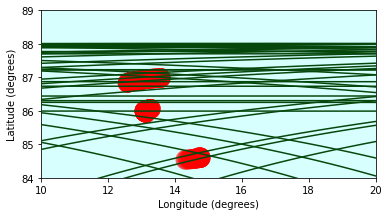

In [20]:
base = country_gpd.plot(color='yellow', edgecolor='black', zorder=1)
base.set_facecolor('#d7fffe')
# Close-up view
base.set_xlim(10, 20)
base.set_ylim(84, 89)
# Global view
# base.set_xlim(-180, 180)
# base.set_ylim(-90, 90)
base.set_xlabel('Longitude (degrees)')
base.set_ylabel('Latitude (degrees)')
orbit = orbit_gpd.plot(ax=base, color='#06470c', zorder=3)
soda = cruise_gpd.plot(ax=orbit, color='red', alpha=0.6, zorder=2)